In [1]:
import numpy as np
from esis.data import level_3, level_4
from esis.data.inversion import mart
import astropy.units as u
import kgpy.img.coalignment.image_coalignment as kgpy_img
import astropy.wcs as wcs
import multiprocessing as mp
import skimage.transform
from kgpy.multiprocess_tools.mp_wrapper import starmap_with_kwargs
from itertools import repeat
import time
import matplotlib.pyplot as plt
from esis.data.inversion.mart import forward

%reload_ext autoreload
%autoreload 2
%matplotlib notebook


<IPython.core.display.Javascript object>


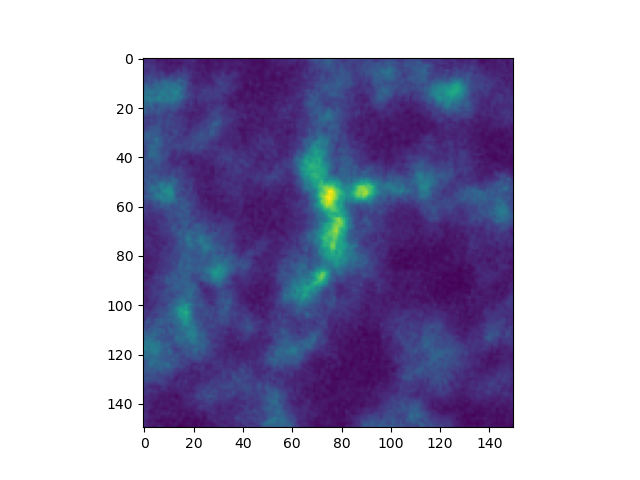

In [2]:
ov = level_3.Level3.from_pickle(level_3.ov_final_path)
ov_data = ov.observation.data * ov.observation.mask
angles = (np.arange(4)*45 + 22.5 - 90)* u.deg

event = [slice(80,1120),slice(80,1120)]
pad = 0

# event = [slice(180,280),slice(500,780)]
# pad = 20
#

#no Mg X
event = [slice(850,1000),slice(600,750)]
pad = 20

# event = [slice(500,600),slice(650,750)]
# pad = 20

region = ov_data[:,:,event[0],event[1]]
fig,ax = plt.subplots()
ax.imshow(region[15,3])

In [3]:


x,y = kgpy_img.get_img_coords(region[0,0])
x0,y0 = [region.shape[-2] // 2, region.shape[-1] //2]
len_scl = min(region.shape[-1],region.shape[-2])/2.5
window = np.exp(-(np.sqrt(np.square(x-x0) + np.square(y-y0))/len_scl)**(6))
window=window.T
# window = np.ones_like(region[0])

guess = np.ones_like(region[0,0])*window
guess = np.pad(guess,((pad,pad),(pad,pad)))

guess = guess[None,:,:]

guess = np.resize(guess,(41,guess.shape[-2],guess.shape[-1]))
guess = np.moveaxis(guess,0,-1)


spectral_order = np.array([1])
mart_obj = mart.MART(
    use_maximize=True,
    use_filter=True,
    use_lgof = True,
    anti_aliasing=None,
    max_multiplicative_iteration=100,
    max_filtering_iterations=30,
    photon_read_noise = 1.5,
    # track_cube_history='filter',
    contrast_exponent=.4,
    # rotation_kwargs=rotation_kwargs,
    verbose = True

)

ref_wavelen = guess.shape[-1] // 2
recovered_list = []

# seqs = [i for i in range(ov.observation.data.shape[0])]
seqs = [19]

projections_list = []
for seq in seqs:
    projections = []
    for i,angle in enumerate(angles):
        # projection = scipy.ndimage.rotate(np.pad(region[seq,i]*window,((pad,pad),(pad,pad))),angle,**rotation_kwargs)
        projection = skimage.transform.rotate(np.pad(region[seq,i]*window,((pad,pad),(pad,pad))),angle.value)
        projections.append(projection)


    projections = np.array(projections)
    projections = projections[None,:,:,:,None]
    projections[projections<0] = 0
    projections_list.append(projections)




p = mp.Pool(mp.cpu_count()//2)
# p = mp.Pool(len(seqs))
args_iter = zip(projections_list,repeat(angles),repeat(np.array(spectral_order)))
kwargs_iter = repeat(dict(cube_offset_x=ref_wavelen,cube_guess=guess))

start = time.time()
recovered_list = starmap_with_kwargs(p,mart_obj,args_iter,kwargs_iter)
print('Total Inversion Time = ',time.time()-start)

---------------------------------------------
Filtering Iteration Number  0
Starting MART Iterations


/media/jake/Media/Documents/Research/Kankelborg Group/ESIS/esis/data/inversion/mart/simple_mart.py:146: RuntimeWarning: invalid value encountered in true_divide
  ratio = projection / test_projection
/media/jake/Media/Documents/Research/Kankelborg Group/ESIS/esis/data/inversion/mart/forward.py:160: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  shifted_projection[tuple(out_sl)] = projection[in_sl]
/media/jake/Media/Documents/Research/Kankelborg Group/ESIS/esis/data/inversion/mart/forward.py:174: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.


MART Converged at iteration  3
Starting MART Iterations
MART Converged at iteration  23
---------------------------------------------
Filtering Iteration Number  1
Starting MART Iterations
MART Converged at iteration  0
Starting MART Iterations
MART Converged at iteration  13
---------------------------------------------
Filtering Iteration Number  2
Starting MART Iterations
MART Converged at iteration  0
Starting MART Iterations
MART Converged at iteration  13
---------------------------------------------
Filtering Iteration Number  3
Starting MART Iterations
MART Converged at iteration  0
Starting MART Iterations
MART Converged at iteration  17
---------------------------------------------
Filtering Iteration Number  4
Starting MART Iterations
MART Converged at iteration  0
Starting MART Iterations
MART Converged at iteration  15
---------------------------------------------
Filtering Iteration Number  5
Starting MART Iterations
MART Converged at iteration  1
Starting MART Iterations

20


<IPython.core.display.Javascript object>


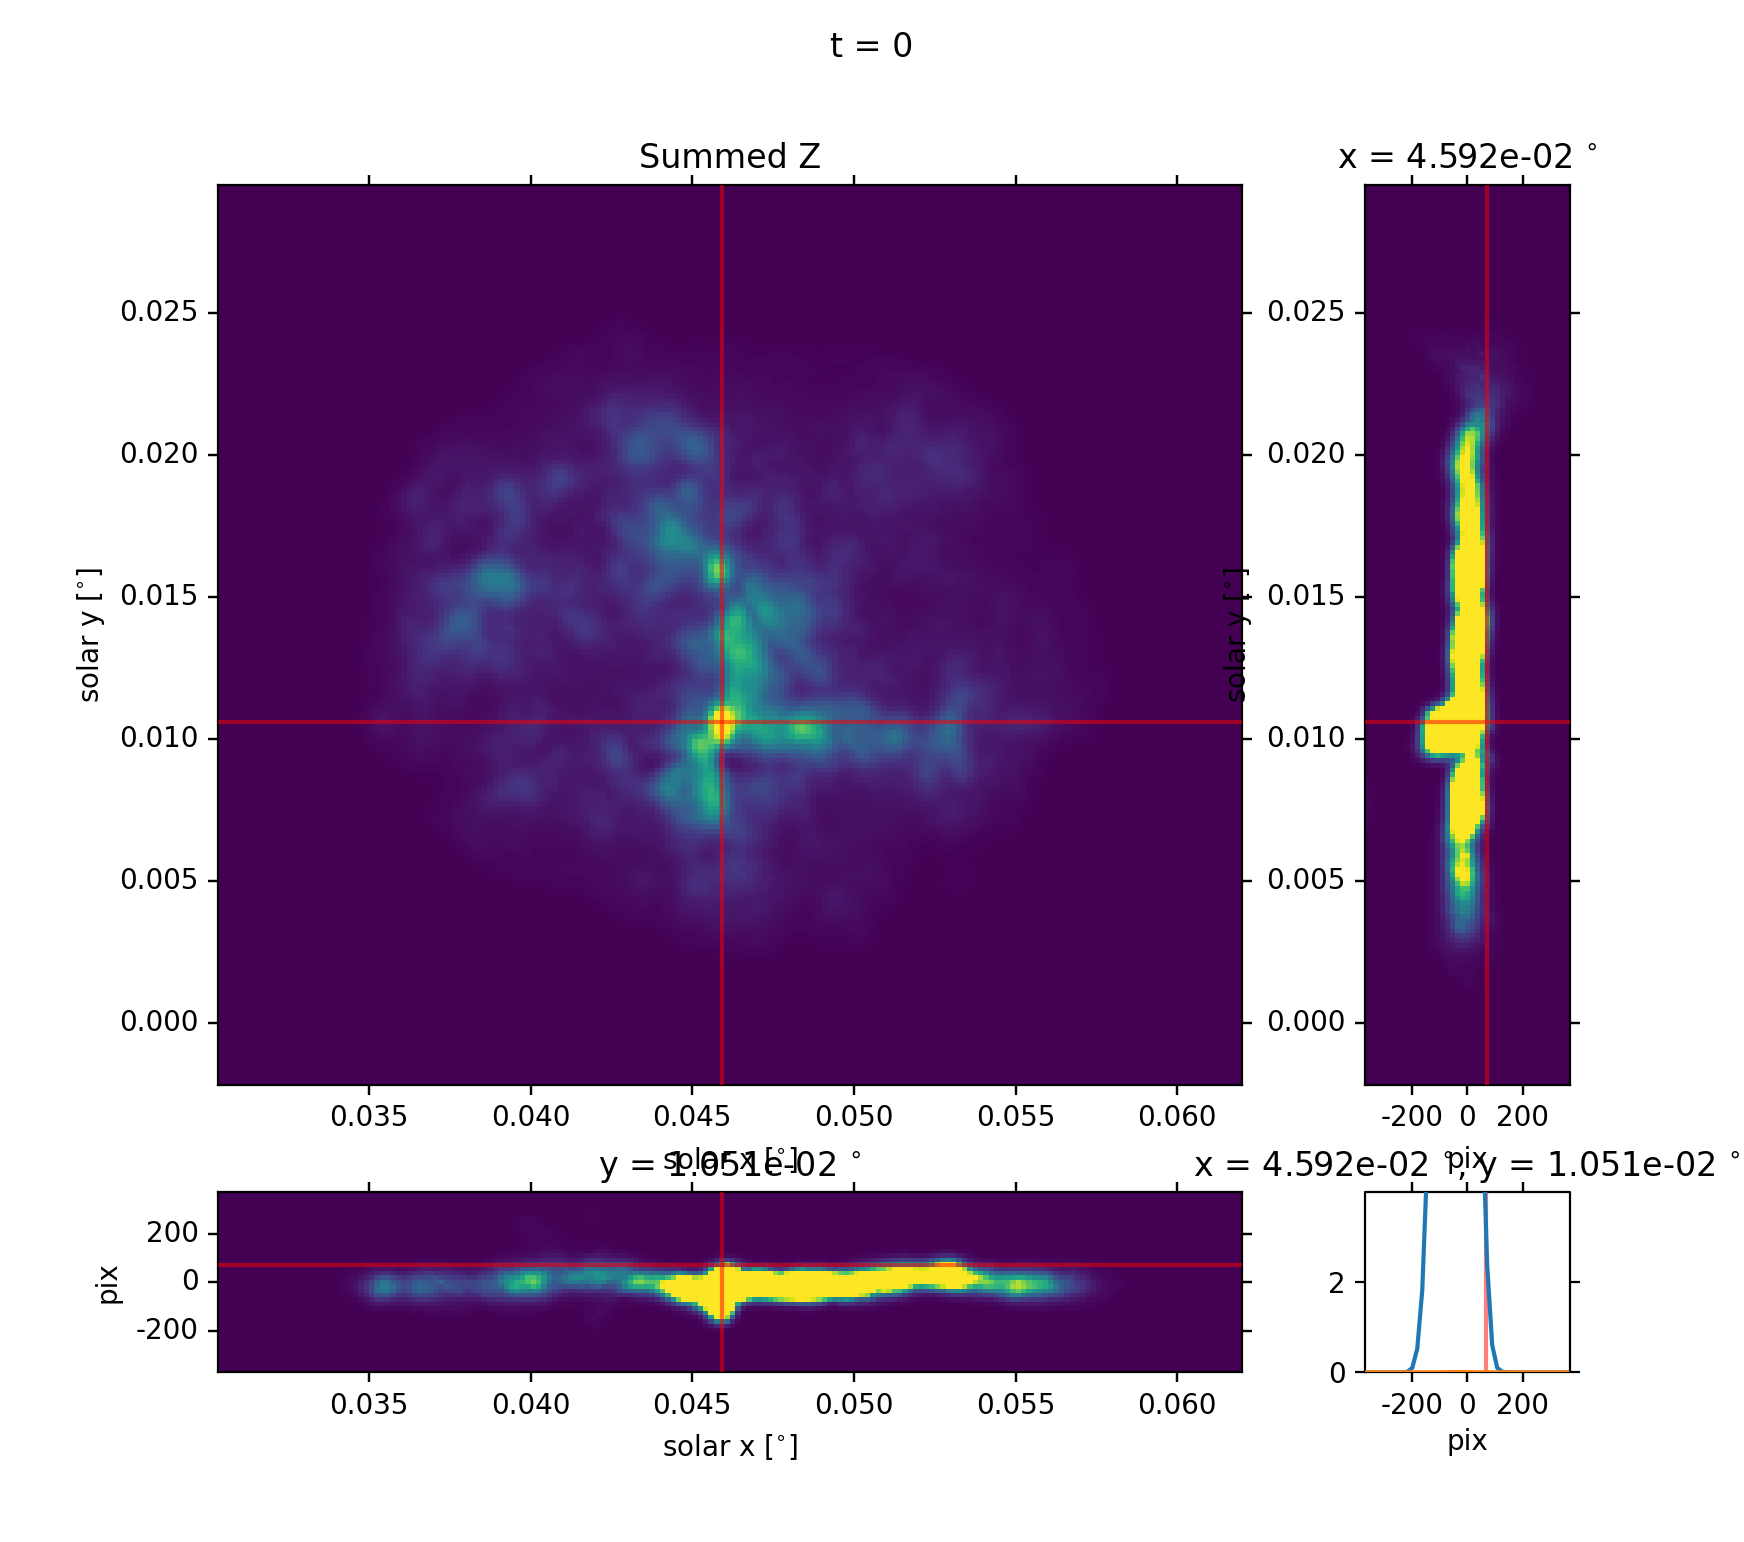

In [4]:
image_wcs = ov.observation[0,0,event[0],event[1]].wcs.dropaxis(-1)
image_wcs = image_wcs.dropaxis(-1)
print(ref_wavelen)

header = image_wcs.to_header()
header['ctype1'] = 'Solar Y'
header['ctype2'] = 'Solar X'
header['naxis'] = 3
header['ctype3'] = 'pix'
header['crval3'] = -18
header['crpix3'] = ref_wavelen
header['cdelt3'] = 18
header['naxis3'] = guess.shape[-1]

result_wcs = wcs.WCS(header)
result_wcs = result_wcs.swapaxes(-1,0)
result_wcs.array_shape = guess.shape


inverted_results = np.array([recovered_list[i].best_cube for i in range(len(recovered_list))])
inverted_results_wcs = [result_wcs for i in range(len(recovered_list))]


lev4 = level_4.Level_4(inverted_results,inverted_results_wcs)
lev4.plot()

<IPython.core.display.Javascript object>


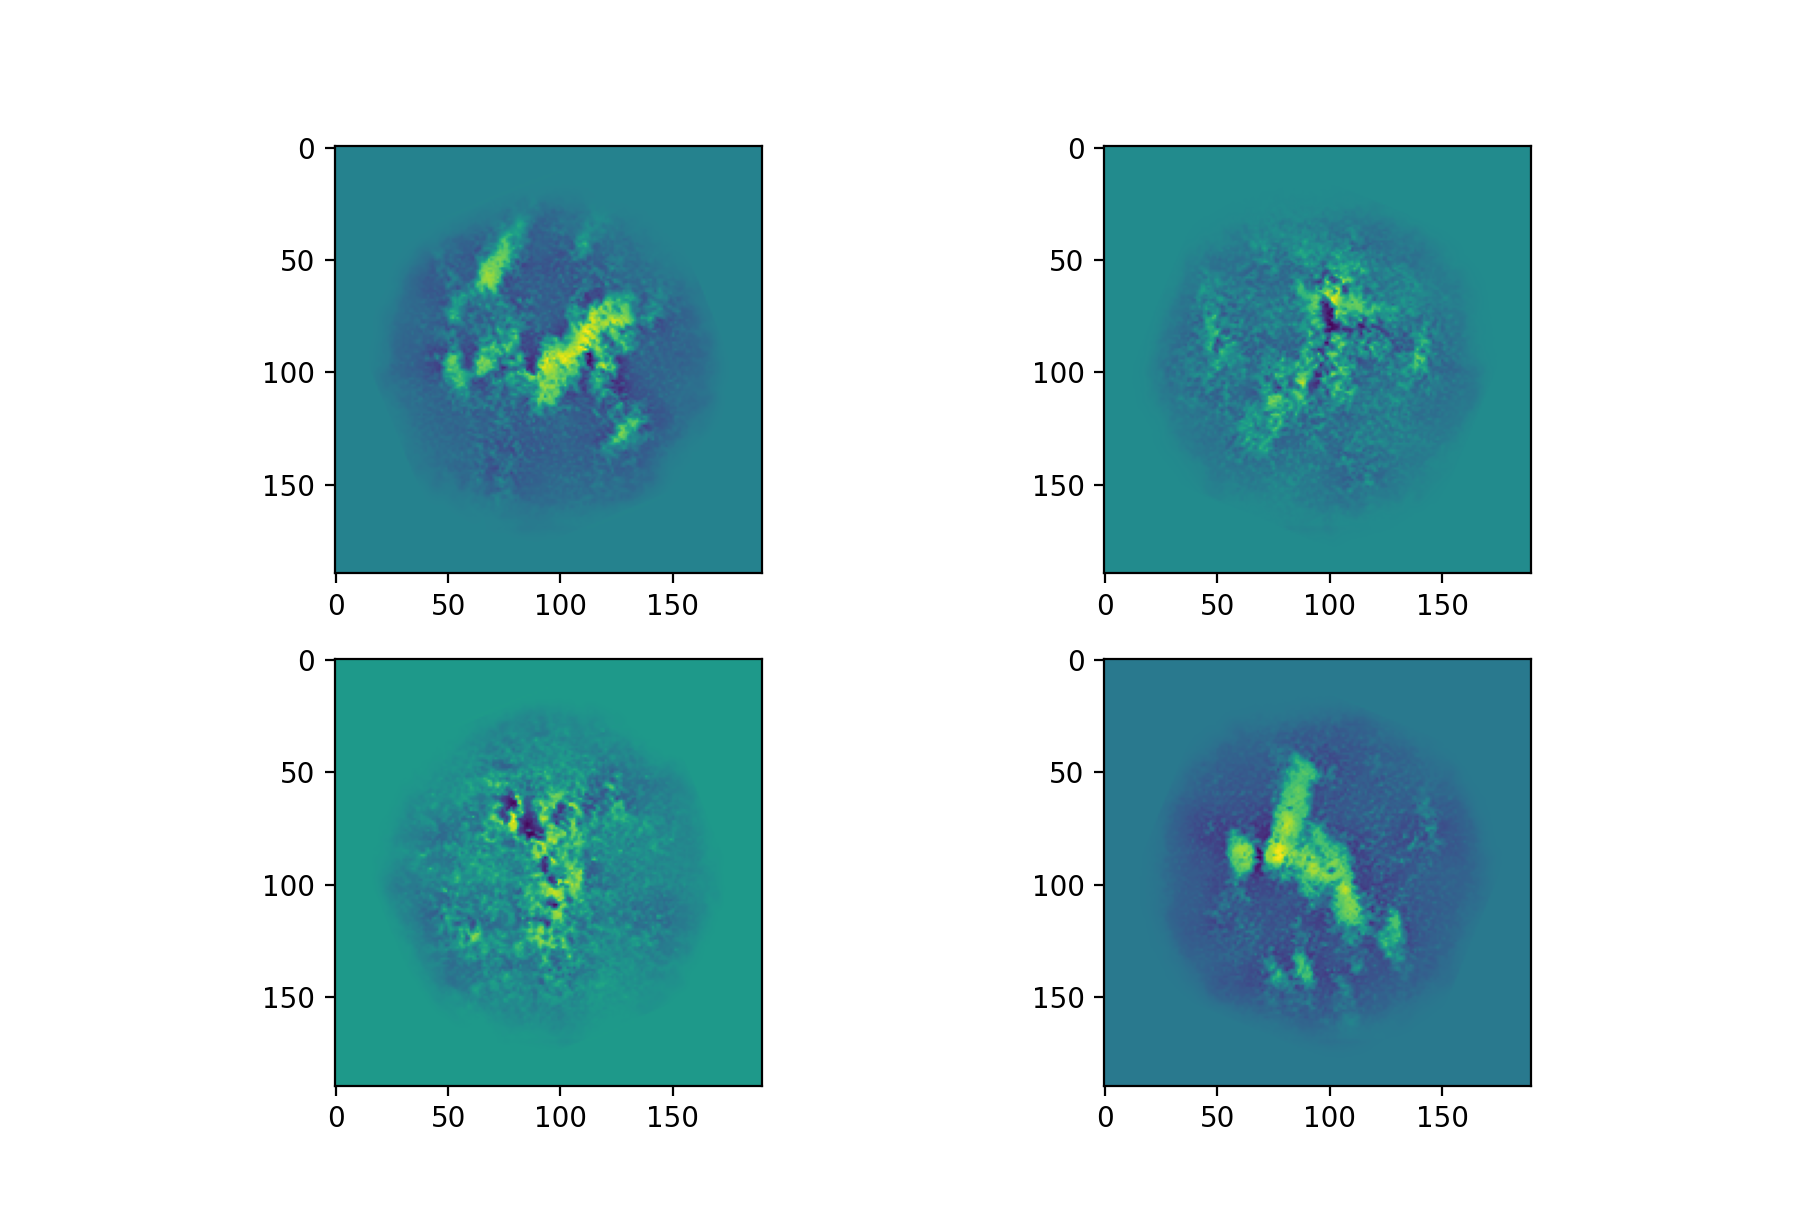

0.130558354714292


In [6]:
test_projections = np.empty_like(projections_list[0])
for i,ang in enumerate(angles):
    test_projection = forward.model(inverted_results[0],
                                    angles[i],spectral_order[0],
                                    projection_shape=projections_list[0][0,i].shape,
                                    cube_spatial_offset= (ref_wavelen,0),
                                    )
    test_projections[0,i,...] = test_projection
residual = np.squeeze(test_projections) - np.squeeze(projections_list[0])

fig, axs = plt.subplots(2,2)
axs = axs.flatten()
for i,ax in enumerate(axs):
    im = ax.imshow(residual[i,...])
    
print(np.sum(np.abs(residual)) / np.sum(np.abs(np.squeeze(projections_list[0]))))



